In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import os
import matplotlib.image as mpimg

In [2]:

def getTrainTest(listSignsDirectory, sampleDiv, pTrain, typeIm):
    
    train = []
    test = []
    trainLabels = []
    testLabels = []
    
    for directory in listSignsDirectory:
        
        relativePath = "../dataset/" + directory
        
        # Get number frames
        nFiles = len(os.listdir(os.path.abspath(relativePath)))   
        
        # Random sample of Data for Train - Test
        sample = random.sample(range(1,nFiles), round(nFiles/sampleDiv))
        nTrain = int(round(round(nFiles/sampleDiv)*pTrain))
        
        print("Reading " + str(round(nFiles/sampleDiv)) + " random frames from " + relativePath)
        
        # Reading random sample
        for frame in sample[:nTrain]:
            img = cv2.imread(relativePath + "/" + directory + "_" + str(frame) + ".jpg", typeIm)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            train.append(img)
            
        for frame in sample[nTrain:]:
            img = cv2.imread(relativePath + "/" + directory + "_" + str(frame) + ".jpg", typeIm)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            test.append(img)
        #Hacemos one_hot encode
        one_hot = [0] * 5
        one_hot[int(directory[-1]) - 1] = 1
        trainLabels.append( [one_hot] * nTrain)
        testLabels.append( [one_hot] * (round(nFiles/sampleDiv) - nTrain))
        
    
    trainLabels = [item for sublist in trainLabels for item in sublist]
    testLabels = [item for sublist in testLabels for item in sublist]
    #Hacemos one_hot encode
    #one_hot = [0] * 5
    #one_hot[code - 1] = 1
    #y.append(one_hot)
    
    print("Shuffling data...\n")   
    zipped = list(zip(train, trainLabels))
    random.shuffle(zipped)
    train, trainLabels = zip(*zipped)

    zipped = list(zip(test, testLabels))
    random.shuffle(zipped)
    test, testLabels = zip(*zipped)
    
    return train, trainLabels, test, testLabels


In [3]:
listSignsDirectory = ["sign_1", "sign_2", "sign_3", "sign_4", "sign_5"]
train, trainLabels, test, testLabels = getTrainTest(listSignsDirectory, 4, 0.8,cv2.COLOR_BGR2RGB)
train = np.array(train)
trainLabels = np.array(trainLabels)
test = np.array(test)
testLabels = np.array(testLabels)


Reading 375 random frames from ../dataset/sign_1
Reading 368 random frames from ../dataset/sign_2
Reading 406 random frames from ../dataset/sign_3
Reading 356 random frames from ../dataset/sign_4
Reading 350 random frames from ../dataset/sign_5
Shuffling data...



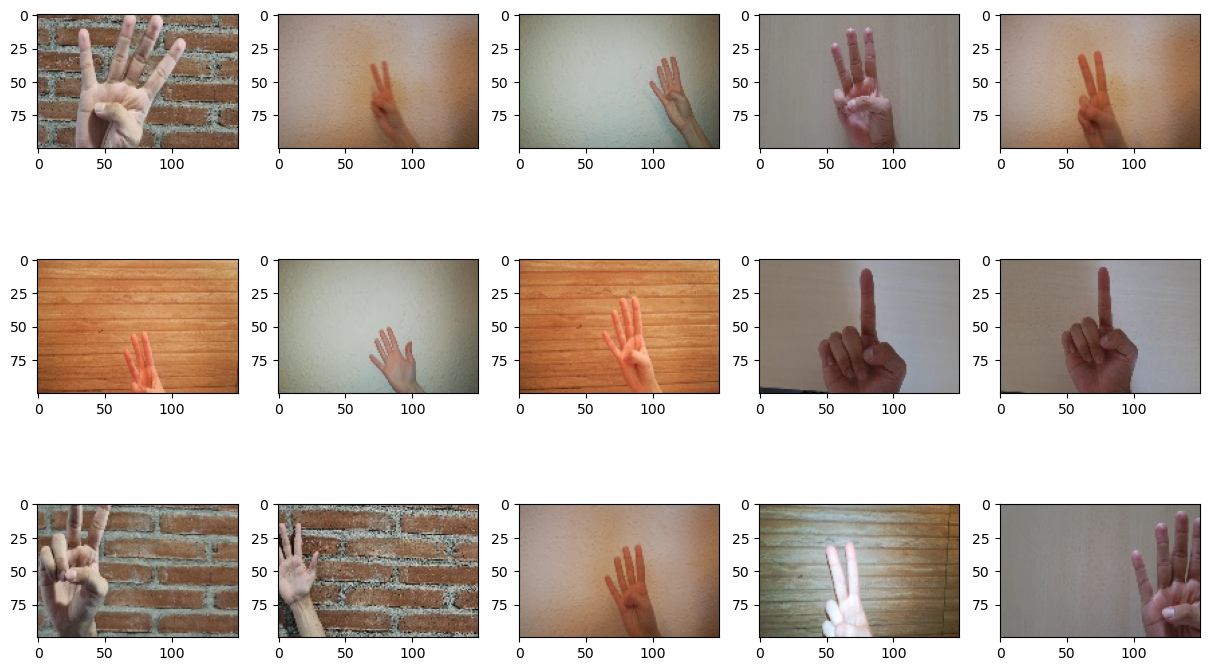

In [4]:
plt.figure(figsize=(15,9))
for i, imagen in enumerate(train[:15]):
    plt.subplot(3, 5,i+1)
    #Imprimim en blanc i negre
    #plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.imshow(imagen)

In [5]:
print(train.shape)
print(trainLabels.shape)
print(test.shape)
print(testLabels.shape)
print(trainLabels[0:4])

(1484, 100, 150, 3)
(1484, 5)
(371, 100, 150, 3)
(371, 5)
[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]


## Funcio per representar graficament els resultats:

In [6]:
#caracters de sortida:
class_names = [1,2,3,4,5]

def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    index = np.where(true_label == 1)[0][0]
    #index += 1
    #print(index)
    predicted_label = np.argmax(predictions_array)
    #print(predicted_label)
    if predicted_label == index:
        color = 'blue'
    else:
        color = 'red'
    #print(class_names[predicted_label])
    plt.xlabel(f"Prediccion: {predicted_label+1}", color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    #print(predictions_array.max())
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#888888")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    index = np.where(true_label == 1)[0][0]
    
    thisplot[predicted_label].set_color('red')
    thisplot[index].set_color('blue')

# Obtenemos las predicciones del modelo utilizando X_test como entrada

def tablaAciertos(predictions, labels, imatges):
    #print(X_test[0].shape)
    numrows=5
    numcols=3
    numimages = numrows*numcols

    plt.figure(figsize=(2*2*numcols, 2*numrows))

    # Iteramos sobre las primeras 15 imágenes y etiquetas de X_test y y_test
    for i in range(15):
      plt.subplot(numrows, 2*numcols, 2*i+1)
      plot_image(i, predictions, labels, imatges)
      plt.subplot(numrows, 2*numcols, 2*i+2)
      plot_value_array(i, predictions, labels)

    plt.show()

In [7]:
#clase Callback para limitante
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## Modelos Redes Neuronales con dataset **Con One hot Encode**
Primero creare todas las redes neuronales con unas *50* neuronas para comparar las diferentes perdidas, modelos etc.
Debido a que mientras mas neuronas, mas capas ocultas mas tarda, por eso los parametros decididos son:

-Una capa de neuronas de entrada tipo Flatten
-Una capa densa de 128 neuronas
-Una capa densa de salida

Los parametros decididos para el entrenamiento inicial son:

  -50 Epocas


In [154]:
import tensorflow as tf
from tensorflow.python import metrics
#Modelo con funcion de costo Error Cuadratico Medio (MSE) One Hot Encoded (OHE)
mseModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[100,150,3]), #neuronas de entrada
    tf.keras.layers.Dense(150, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(5, activation=tf.nn.softmax), #capa de salida 5 salidas posibles
])
#Compilar el modelo
mseModelOHE.compile(    
    optimizer = 'adam',
    loss='mean_squared_error',
    metrics = ['accuracy']
)
mseModelOHE.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE) One Hot Encoded (OHE)

mapeModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[100,150,3]), #neuronas de entrada
    tf.keras.layers.Dense(150, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(5, activation=tf.nn.softmax), #capa de salida 5 salidas posibles
])
#Compilar el modelo
mapeModelOHE.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    metrics = ['accuracy']
)
mapeModelOHE.summary()

#Modelo con funcion de costo categorical_crossentropy One Hot Encoded (OHE)

cceModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[100,150,3]), #neuronas de entrada
    tf.keras.layers.Dense(150, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(5, activation=tf.nn.softmax), #capa de salida 5 salidas posibles
])
#Compilar el modelo
cceModelOHE.compile(    
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cceModelOHE.summary()

#Modelo con funcion de costo Porcentage de error absoluto medio (MAPE) One Hot Encoded (OHE)

maeModelOHE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[100,150,3]), #neuronas de entrada
    tf.keras.layers.Dense(150, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(5, activation=tf.nn.softmax), #capa de salida 5 salidas posibles
])
#Compilar el modelo
maeModelOHE.compile(    
    optimizer = 'adam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics = ['accuracy']
)
maeModelOHE.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 45000)             0         
                                                                 
 dense_72 (Dense)            (None, 150)               6750150   
                                                                 
 dense_73 (Dense)            (None, 5)                 755       
                                                                 
Total params: 6,750,905
Trainable params: 6,750,905
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 45000)             0         
                                                                 
 dense_74 (Dense)   

In [145]:
historialMSEOHE = mseModelOHE.fit(train, trainLabels, epochs=50, verbose=False)

In [146]:
historialMAPEOHE = mapeModelOHE.fit(train, trainLabels, epochs=50, verbose=False)

In [147]:
historialCCEOHE = cceModelOHE.fit(train, trainLabels, epochs=50, verbose=False)

In [148]:
historialMAEOHE = maeModelOHE.fit(train, trainLabels, epochs=50, verbose=False)

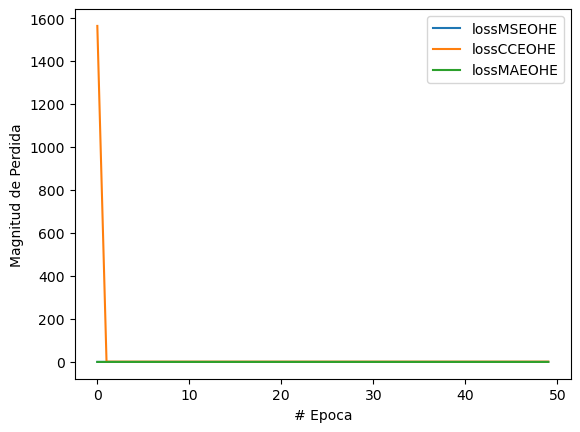

In [157]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Perdida')

plt.plot(historialMSEOHE.history['loss'],label='lossMSEOHE')
#plt.plot(historialMAPEOHE.history['loss'],label='lossMAPEOHE')
plt.plot(historialCCEOHE.history['loss'],label='lossCCEOHE')
plt.plot(historialMAEOHE.history['loss'],label='lossMAEOHE')
plt.legend()

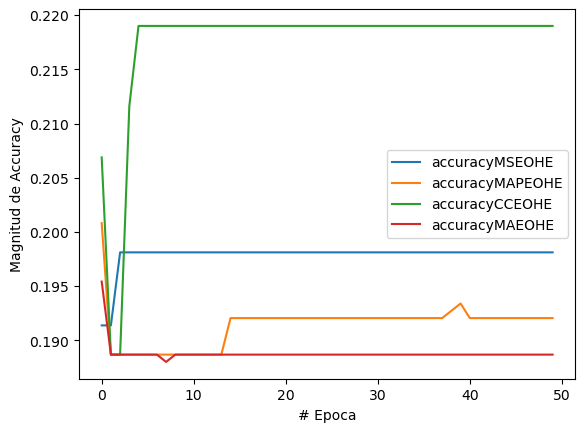

In [150]:
plt.xlabel('# Epoca')
plt.ylabel('Magnitud de Accuracy')

plt.plot(historialMSEOHE.history['accuracy'],label='accuracyMSEOHE')
plt.plot(historialMAPEOHE.history['accuracy'],label='accuracyMAPEOHE')
plt.plot(historialCCEOHE.history['accuracy'],label='accuracyCCEOHE')
plt.plot(historialMAEOHE.history['accuracy'],label='accuracyMAEOHE')
plt.legend()

In [151]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas MSE con OHE: ")
test_loss, test_accuracy = mseModelOHE.evaluate(test, testLabels)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAPE con OHE: ")

test_loss, test_accuracy = mapeModelOHE.evaluate(test, testLabels)


#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas MSE
print("Resultado en las pruebas CCE con OHE: ")
test_loss, test_accuracy = cceModelOHE.evaluate(test, testLabels)

#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas MAE con OHE: ")
test_loss, test_accuracy = maeModelOHE.evaluate(test, testLabels)




Resultado en las pruebas MSE con OHE: 
12/12 [==============================] - 0s 9ms/step - loss: 0.3202 - accuracy: 0.1995
Resultado en las pruebas MAPE con OHE: 
12/12 [==============================] - 0s 6ms/step - loss: 161725056.0000 - accuracy: 0.1914
Resultado en las pruebas CCE con OHE: 
12/12 [==============================] - 0s 5ms/step - loss: 1.6081 - accuracy: 0.2183
Resultado en las pruebas MAE con OHE: 
12/12 [==============================] - 0s 6ms/step - loss: 0.3245 - accuracy: 0.1887


12/12 [==============================] - 0s 7ms/step


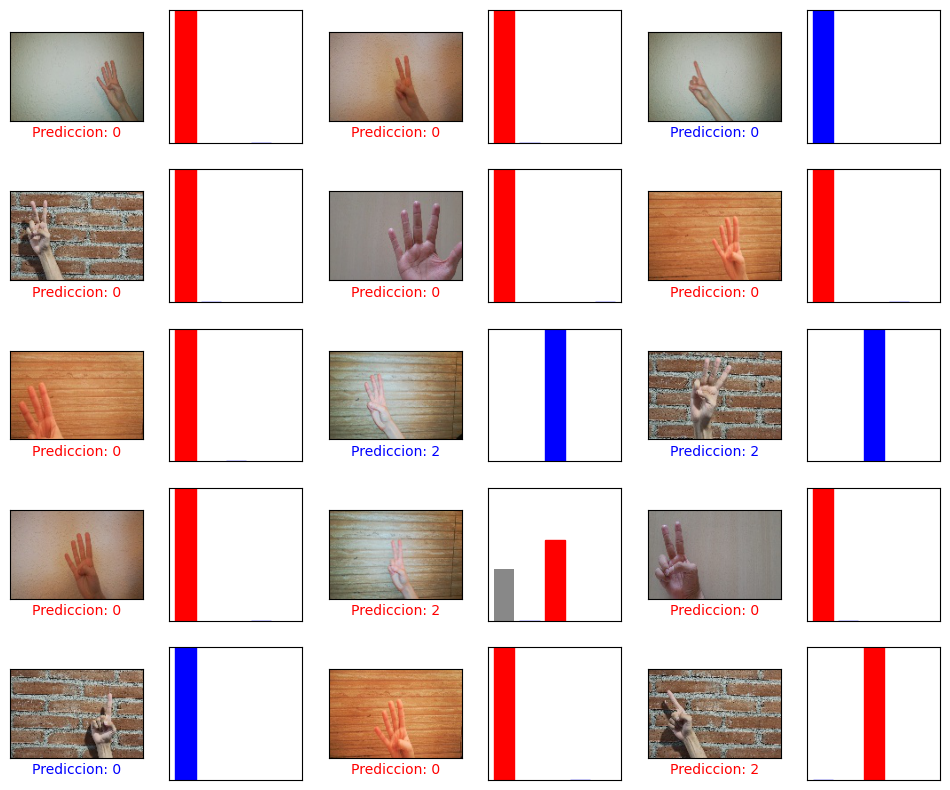

In [156]:
predictions = maeModelOHE.predict(test)
tablaAciertos(predictions, testLabels, test)

## Red neuronal convolucional

In [8]:
#Crear el modelo, este caso tendra 3 capas de 128 neuronas

modelCNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=[100, 150, 3], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),#2,2 es el tamaño de la matriz
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=[100, 150, 3], activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),#2,2 es el tamaño de la matriz
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #1a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(128, activation=tf.nn.relu), #2a capa oculta activacion relu
    tf.keras.layers.Dense(5, activation=tf.nn.softmax), #capa de salida 15 salidas posibles
])
modelCNN.compile(
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 52992)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [10]:
historialCNN = modelCNN.fit(train, trainLabels, epochs = 100)

Epoch 1/100
47/47 [==============================] - 8s 175ms/step - loss: 1.4218 - accuracy: 0.3922
Epoch 2/100
47/47 [==============================] - 8s 180ms/step - loss: 1.1609 - accuracy: 0.5310
Epoch 3/100
47/47 [==============================] - 9s 201ms/step - loss: 0.9174 - accuracy: 0.6348
Epoch 4/100
47/47 [==============================] - 7s 156ms/step - loss: 0.8804 - accuracy: 0.6557
Epoch 5/100
47/47 [==============================] - 9s 192ms/step - loss: 0.9669 - accuracy: 0.6476
Epoch 6/100
47/47 [==============================] - 8s 170ms/step - loss: 0.6284 - accuracy: 0.7743
Epoch 7/100
47/47 [==============================] - 7s 147ms/step - loss: 0.4935 - accuracy: 0.8214
Epoch 8/100
47/47 [==============================] - 8s 174ms/step - loss: 0.4994 - accuracy: 0.8430
Epoch 9/100
47/47 [==============================] - 9s 201ms/step - loss: 0.2124 - accuracy: 0.9373
Epoch 10/100
47/47 [==============================] - 9s 194ms/step - loss: 0.7539 - accura

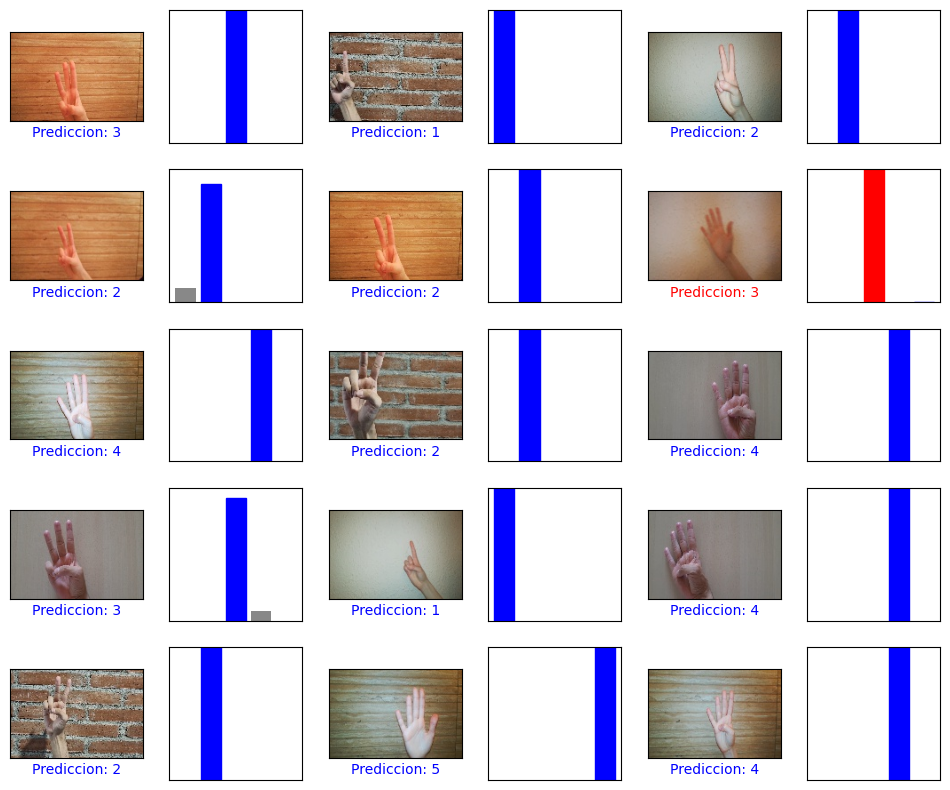

In [13]:
predictions = modelCNN.predict(test, verbose=False)
tablaAciertos(predictions, testLabels, test)

In [17]:
#Evaluar nuestro modelo ya entrenado, contra el dataset de pruebas
print("Resultado en las pruebas CNN con OHE: ")
test_loss, test_accuracy = modelCNN.evaluate(test, testLabels)


Resultado en las pruebas CNN con OHE: 
12/12 [==============================] - 0s 40ms/step - loss: 1.2616 - accuracy: 0.8733


In [18]:
modelCNN.save('../models/modelCNN')

INFO:tensorflow:Assets written to: ../models/modelCNN\assets


INFO:tensorflow:Assets written to: ../models/modelCNN\assets


In [19]:
modelCNN.save('../models/modelCNN.h5')